In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
import seaborn as sns

In [2]:
outpath = "output/visium_meta/"

In [104]:
# dataname = "V1_Mouse_Kidney"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior_Section_2"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior"
dataname = "V1_Mouse_Brain_Sagittal_Posterior_Section_2"

# dataname = "cta_ucsf-1-5_liver"

# dataname = "p20190_s003_3_BrainMetastasis"
# dataname = "p20190_s004_4_BrainMetastasis"
# dataname = "p20218_s001_L1"
# dataname = "p20218_s002_L2"
# dataname = "p20218_s003_L3"

# dataname = "Visium_FFPE_Human_Breast_Cancer"
# dataname = "Visium_FFPE_Human_Normal_Prostate"
# dataname = "Visium_FFPE_Human_Prostate_Acinar_Cell_Carcinoma"
# dataname = "Visium_FFPE_Human_Prostate_Cancer"
# dataname = "Visium_FFPE_Human_Prostate_IF"
# dataname = "Visium_FFPE_Mouse_Brain"
# dataname = "Visium_FFPE_Mouse_Brain_IF"
# dataname = "Visium_FFPE_Mouse_Kidney"

samples = pd.read_csv("output/make_samplesheet/spatial.csv",index_col = 0)
row = samples.loc[dataname]

cer_loc_name = row["tiss_pos_list"]
im_path = row["image"]
filt_bc_name = row["ge_mat"] + "barcodes.tsv.gz"

Image.MAX_IMAGE_PIXELS = 692696316
bound = 5
rank_quant = "_r_0.01"

# blur over spot
blurval = 70
q = 10

  
# load in tissue positions list and image

cer_loc = pd.read_csv(cer_loc_name,names = ["barcode","in_tissue","array_row","array_col","xcoord","ycoord"])
filt_bc = pd.read_csv(filt_bc_name,names=["barcode"])

# subset to only spots in the tissue (by spaceranger)
cer_loc = cer_loc[cer_loc["barcode"].isin(set(filt_bc["barcode"]))]

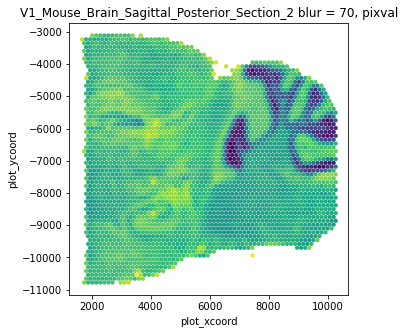

In [105]:
cer_loc["cell_id"] = dataname + "_" + cer_loc["barcode"].str.split("_").str[0].str[:-2]

# get coordinates that make image line up when plotted
cer_loc["plot_xcoord"] = cer_loc["ycoord"]
cer_loc["plot_ycoord"] = -cer_loc["xcoord"]

# get rid of outliers
while (list(cer_loc["plot_xcoord"].sort_values())[1] - list(cer_loc["plot_xcoord"].sort_values())[0]) > 1000:
  cer_loc = cer_loc[cer_loc["plot_xcoord"] > list(cer_loc["plot_xcoord"].sort_values())[0]]
  
while (list(cer_loc["plot_xcoord"].sort_values())[-1] - list(cer_loc["plot_xcoord"].sort_values())[-2]) > 1000:
  cer_loc = cer_loc[cer_loc["plot_xcoord"] < list(cer_loc["plot_xcoord"].sort_values())[-1]]

# load image, convert to grayscale, and blur
img = Image.open(im_path)
img = img.convert('L')
img = img.filter(ImageFilter.GaussianBlur(radius=blurval))
blur = np.array(img)

if dataname in ["p20190_s003_3_BrainMetastasis"]:
  blur = np.flip(blur.T)
  cer_loc["plot_xcoord"] = -cer_loc["xcoord"]
  cer_loc["plot_ycoord"] = cer_loc["ycoord"]

# get pixel values from the image
cer_loc["pixval"] = -1
for index, row in cer_loc.iterrows():
  cer_loc.loc[index,"pixval"] = blur[row["xcoord"],row["ycoord"]]

# plot raw pixvals
plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixval",size=3,linewidth=0,palette="viridis",legend=False)
plt.title("{} blur = {}, pixval".format(dataname,blurval))


plt.savefig("{}{}_pixval.png".format(outpath,dataname))
plt.show()



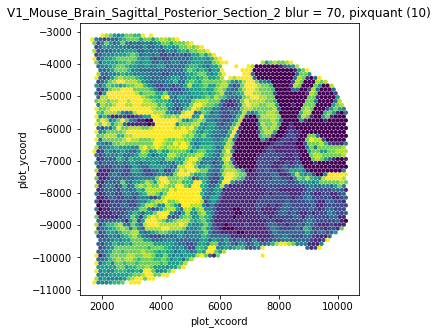

In [106]:
# quantile pixvals
temp = cer_loc.drop_duplicates("barcode")[["barcode","pixval"]]

# decrease the number of quantiles if necessary (all of the same value don't fit in a bin)
qval = q
while True:
  try:
    temp["pixquant"] = pd.qcut(temp['pixval'], qval, labels=False)
    break
  except:
    qval -= 1
    print(qval)
temp.index = temp["barcode"]
cer_loc["pixquant"] = cer_loc["barcode"].map(temp["pixquant"])

# plot quantiled pixvals
plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixquant",size=3,linewidth=0,palette="viridis",legend=False)
plt.title("{} blur = {}, pixquant ({})".format(dataname,blurval,q))
plt.savefig("{}{}_pixquant.png".format(outpath,dataname))

plt.show()
img.save("{}{}_blur.png".format(outpath,dataname))
img.show()

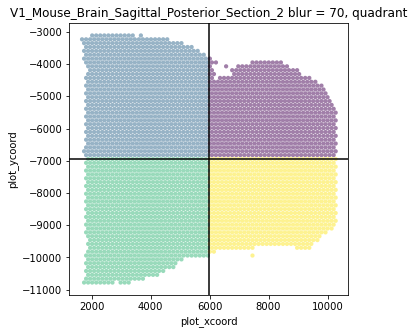

In [107]:
# plot raw pixvals


xhalf = (cer_loc["plot_xcoord"].max() - cer_loc["plot_xcoord"].min())/2 + cer_loc["plot_xcoord"].min()
yhalf = (cer_loc["plot_ycoord"].max() - cer_loc["plot_ycoord"].min())/2 + cer_loc["plot_ycoord"].min()
cer_loc["quadrant"] = 1

cer_loc.loc[(cer_loc["plot_xcoord"] <= xhalf) & (cer_loc["plot_ycoord"] > yhalf),"quadrant"] = 2
cer_loc.loc[(cer_loc["plot_xcoord"] <= xhalf) & (cer_loc["plot_ycoord"] <= yhalf),"quadrant"] = 3
cer_loc.loc[(cer_loc["plot_xcoord"] > xhalf) & (cer_loc["plot_ycoord"] <= yhalf),"quadrant"] = 4
  


plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="quadrant",size=3,linewidth=0,palette="viridis",legend=False,color="gray",alpha = 0.5)
plt.title("{} blur = {}, quadrant".format(dataname,blurval))
plt.axvline(x=xhalf,color="k")
plt.axhline(y=yhalf,color="k")
plt.savefig("{}{}_quadrant.png".format(outpath,dataname))
plt.show()





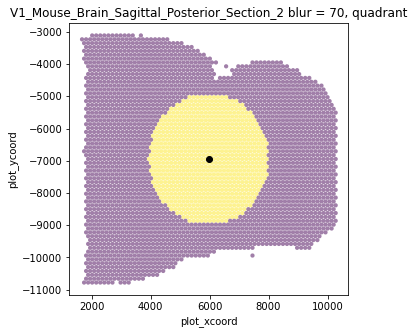

In [108]:
# plot raw pixvals



xhalf = (cer_loc["plot_xcoord"].max() - cer_loc["plot_xcoord"].min())/2 + cer_loc["plot_xcoord"].min()
yhalf = (cer_loc["plot_ycoord"].max() - cer_loc["plot_ycoord"].min())/2 + cer_loc["plot_ycoord"].min()

# average of halfway between middle and outside of tissue (x and y axes)
radius = ((xhalf - cer_loc["plot_xcoord"].min())/2 + (yhalf - cer_loc["plot_ycoord"].min())/2)/2


cer_loc["circle"] = 1

cer_loc["dist_from_center"] = np.sqrt(((cer_loc["plot_xcoord"] - xhalf)**2 + (cer_loc["plot_ycoord"] - yhalf)**2))
cer_loc.loc[(cer_loc["dist_from_center"] < radius),"circle"] = 2




plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="circle",size=3,linewidth=0,palette="viridis",legend=False,color="gray",alpha = 0.5)
plt.title("{} blur = {}, quadrant".format(dataname,blurval))
# plt.axvline(x=xhalf,color="k")
# plt.axhline(y=yhalf,color="k")
plt.plot(xhalf,yhalf,marker="o",color="k")
plt.savefig("{}{}_quadrant.png".format(outpath,dataname))
plt.show()





In [111]:
df = pd.read_parquet("/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium_2_June_2022/V1_Mouse_Brain_Sagittal_Posterior/SpliZ_values/V1_Mouse_Brain_Sagittal_Posterior_sym_SVD_normdonor_S_0.1_z_0.0_b_5_r_0.01.pq")

In [114]:
meta = pd.read_csv("/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/visium_meta/meta_V1_Mouse_Brain_Sagittal_Posterior.tsv",sep="\t")

['refName_newR1',
 'gene',
 'juncStart',
 'juncEnd',
 'chrR1A',
 'numReads',
 'cell',
 'exon_annR1A',
 'exon_annR1B',
 'both_ann',
 'sort_junc',
 'splice_ann',
 'called',
 'dummy',
 'numReads_tot',
 'geneR1B_uniq',
 'sign',
 'cell_gene',
 'posA_group',
 'posB_group',
 'rank_acc',
 'rank_don',
 'bottom_acc_quant',
 'top_acc_quant',
 'bottom_don_quant',
 'top_don_quant',
 'max_rank_acc',
 'max_rank_don',
 'noncon_count',
 'posStart_group',
 'max_rank',
 'sum_reads_group',
 'read_x_acc',
 'num',
 'rank_mean',
 'sq_diff',
 'don_num',
 'don_sigma',
 'S_ijk_Start',
 'S_ijk_Start_unpinned',
 'n_sijk',
 'n_s',
 'n_gene',
 'sijkStart_mean',
 'sd_num',
 'sijkStart_var',
 'n.g_Start',
 'nSijkStart',
 'mult',
 'z_Start',
 'scaled_z_Start',
 'cell_gene_junc',
 'x_sijk',
 'denom_sq',
 'temp',
 'temp_mag',
 'idxmax_z',
 'junc_max_Start',
 'max_don_z_Start',
 'num_ann',
 'z_Start_ann',
 'num_unann',
 'z_Start_unann',
 'posEnd_group',
 'read_x_don',
 'S_ijk_End',
 'S_ijk_End_unpinned',
 'sijkEnd_mean',

In [124]:
df[[x for x in df.columns if x not in meta.columns]].merge(meta,left_on="cell",right_on="cell_id")

refName_newR1     gene  \
0       chr1:Col19a1:24319588:-|chr1:unknown:24615643:...  Col19a1   
1       chr1:Col19a1:24320898:-|chr1:unknown:24615643:...  Col19a1   
2       chr1:Col19a1:24349712:-|chr1:unknown:24613190:...  Col19a1   
3       chr1:Col19a1:24540859:-|chr1:unknown:24613187:...  Col19a1   
4         chr1:Cops9:92637403:-|chr1:Cops9:92639687:-|lin    Cops9   
...                                                   ...      ...   
302072  chr7:Rpl27a:109520642:+|chr7:Rpl27a:109521601:...   Rpl27a   
302073  chrY:Erdr1_1:90785979:+|chrY:Erdr1_1:90816349:...  Erdr1_1   
302074  chrY:Erdr1_1:90785979:+|chrY:Erdr1_1:90793296:...  Erdr1_1   
302075  chrY:Erdr1_1:90793417:+|chrY:Erdr1_1:90816349:...  Erdr1_1   
302076  chrY:Erdr1_1:90793680:+|chrY:Erdr1_1:90816349:...  Erdr1_1   

          juncStart      juncEnd chrR1A  numReads  \
0        24319588.0   24615643.0   chr1       1.0   
1        24320898.0   24615643.0   chr1       2.0   
2        24349712.0   24613190.0   chr1       1.0   
3        24540859.0   24613187.0   chr1       1.0   
4        92637403.0   92639687.0   chr1       4.0   
...             ...          ...    ...       ...   
302072  109520642.0  109521601.0   chr7       5.0   
302073   90785979.0   90816349.0   chrY       1.0   
302074   90785979.0   90793296.0   chrY       2.0   
302075   90793417.0   90816349.0   chrY       1.0   
302076   90793680.0   90816349.0   chrY       3.0   

                                                     cell  exon_annR1A  \
0       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        False   
1       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        False   
2       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        False   
3       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        False   
4       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...         True   
...                                                   ...          ...   
302072  V1_Mouse_Brain_Sagittal_Posterior_TCTTACAGAGGT...         True   
302073  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...         True   
302074  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...         True   
302075  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...         True   
302076  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...        False   

        exon_annR1B  both_ann  ... xcoord  ycoord  \
0             False     False  ...   8368    8869   
1             False     False  ...   8368    8869   
2             False     False  ...   8368    8869   
3             False     False  ...   8368    8869   
4              True      True  ...   8368    8869   
...             ...       ...  ...    ...     ...   
302072         True      True  ...   3216    4531   
302073         True      True  ...   6211    6527   
302074         True      True  ...   6211    6527   
302075         True      True  ...   6211    6527   
302076         True     False  ...   6211    6527   

                                                  cell_id plot_xcoord  \
0       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        8869   
1       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        8869   
2       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        8869   
3       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        8869   
4       V1_Mouse_Brain_Sagittal_Posterior_GACCAAACGTTG...        8869   
...                                                   ...         ...   
302072  V1_Mouse_Brain_Sagittal_Posterior_TCTTACAGAGGT...        4531   
302073  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...        6527   
302074  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...        6527   
302075  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...        6527   
302076  V1_Mouse_Brain_Sagittal_Posterior_CGTGCAGACTGG...        6527   

        plot_ycoord pixval  pixquant quadrant circle dist_from_center  
0             -8368    133         4        4      1      3735.271075  
1             -8368

In [109]:

# save new file
cer_loc.to_csv("{}meta_{}.tsv".format(outpath,dataname),sep="\t",index=False)
print("{}meta_{}.tsv".format(outpath,dataname))

# for ReadZS we can't include hyphen in cell ids
if "-" in dataname:
  cer_loc["cell_id"] = cer_loc["cell_id"].replace("-","_") 
  cer_loc.to_csv("{}meta_{}.tsv".format(outpath,dataname.replace("-","_")),sep="\t",index=False)
  print("{}meta_{}.tsv".format(outpath,dataname.replace("-","_")))

output/visium_meta/meta_V1_Mouse_Brain_Sagittal_Posterior_Section_2.tsv
